In [222]:
import os

import pandas as pd
import numpy as np
import utils.dhs_config as dhs_config
import utils.dhs_utils as dhs

In [223]:
import matplotlib.pyplot as plt

In [2]:
# Main folder with respect from the scripts
MAIN = "../"

# Data folder
DATA = os.path.join(MAIN, "data")

# Raw data folder (where .sav files are)
RAW_DATA = os.path.join(DATA, "raw")

# Transformed data folder
TRS_DATA = os.path.join(DATA, "transformed")

column_variables, column_others = dhs_config.get_columns()

if not(os.path.exists(os.path.join(TRS_DATA, 'df_all.csv'))):
    df_all, couple_all = dhs.get_all_data(RAW_DATA,
                                          column_variables + column_others)
    
    # In year 1994 and 1996 there is some change in the psy question
    # so we skip thoses and also only take the variables of interest
    df_reduce = df_all[~df_all.year.isin([1994, 1996])][column_variables]
    couple_reduce = couple_all[~couple_all.year.isin([1994, 1996])]
    couple_clean = couple_reduce[couple_reduce.married == 1]

    # we clean the data and drop schooling as we did not have the time to clean it
    teg_dict, spaar_dict = dhs_config.get_dict()
    df_clean = df_reduce.replace(teg_dict).replace(spaar_dict).drop('scholing', axis=1)
    
    df_all.to_csv(os.path.join(TRS_DATA, 'df_all.csv'))
    couple_all.to_csv(os.path.join(TRS_DATA, 'couple_all.csv'))
    df_clean.to_csv(os.path.join(TRS_DATA, 'df_clean.csv'))
    couple_clean.to_csv(os.path.join(TRS_DATA, 'couple_clean.csv'))

else:
    df_clean = pd.read_csv(os.path.join(TRS_DATA, 'df_clean.csv'), index_col=0)
    couple_clean = pd.read_csv(os.path.join(TRS_DATA, 'couple_clean.csv'), index_col=0)

In [15]:
df_clean.head()

,gez1,gez3,bmi,spaar1,spaar2,spaar3,spaar4,spaar5,spaar6,teg1,...,teg7,teg8,teg9,teg10,teg11,teg12,teg13,teg14,teg15,teg16
199311360002,193.0,Good,22.282477,5,4,5,7,4,4,5,...,5,5,4,2,5,3,5,5,5,3
199316480001,181.0,Excellent,21.366869,6,4,4,6,2,4,4,...,5,4,6,1,7,1,7,6,6,1
199302570001,184.0,Not so good,33.081285,6,4,4,6,2,2,6,...,4,7,7,1,1,5,3,4,2,5
199302570002,170.0,Excellent,24.221453,6,6,1,7,1,2,4,...,5,5,4,2,4,2,7,6,6,2
199307690001,178.0,Fair,23.355637,3,4,3,4,3,1,6,...,4,4,3,4,6,4,5,6,5,2


In [413]:
from numpy.linalg import svd
from IPython.display import clear_output

In [ ]:
def sinkhorn(mu1, mu2, C, epsilon=0.1, max_iters=50):
    """Run Sinnkhorn's algorithm"""
    
    K = np.exp(-C/epsilon)
    
    a = np.ones(mu2.shape[0])
    err = 1
    for _ in range(max_iters):
        b = mu1 / K.dot(a)
        a = mu2 / K.T.dot(b)
    
    return a, b

def A_descent(A, t, X, Y, l):
    epsilon = 0.1
    a, b = sinkhorn(mu1, mu2, C, epsilon = 0.1, max_iters=10)
    K = np.exp(-C/0.1)
    pi_A = np.diag(b).dot(K).dot(np.diag(a))
    
    grad = np.diag(pi_A)@((X*Y).sum(axis=1))
    _A = A - t*(np.diag(pi_A)@((X*Y).sum(axis=1)))
    U, S, V = svd(A)
    
    step = (S - t*l)
    step *= (step>0)
    
    print(step)
    diff = np.abs(A - U@np.diag(step)@V).sum()
    
    return U@np.diag(step)@V, diff

In [529]:
df_num = df_clean.drop(["gez3","teg3"], axis=1)

Full = df_num.to_numpy(dtype=float)
mean, std = Full.mean(axis=0), Full.std(axis=0)

X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

In [530]:
X = X[:50, :2]
Y = Y[:50, :2]

In [531]:
X_population_size, X_feature_size = X.shape
Y_population_size, Y_feature_size = Y.shape

mu1 = np.ones(X_population_size)/X_population_size
mu2 = np.ones(Y_population_size)/Y_population_size

A = np.random.randn(X_feature_size, Y_feature_size)
A = A/A.sum()
C = X@A@Y.T
C = C/C.max()

In [532]:
a, b = sinkhorn(mu1, mu2, C, epsilon = 0.1, max_iters=10)
K = np.exp(-C/0.1)
pi_A = np.diag(b).dot(K).dot(np.diag(a))

In [538]:
i, j = 0, 1
k, c = 0, 1

(X[i, :, None]@Y[j, None, :])[k, c] - X[i, k]*Y[j, c]

0.0

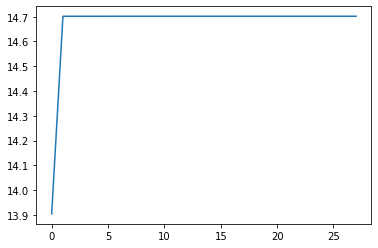

In [533]:
losses = []

epsilon = 0.1
t = 1
l = 0.1

try:
    while diff >= 1e-6:
        C = X@A@Y.T
        C = C/C.max()

        a, b = sinkhorn(mu1, mu2, C, epsilon = 0.1, max_iters=10)
        K = np.exp(-C/0.1)
        pi_A = np.diag(b).dot(K).dot(np.diag(a))
        grad = 0
        coeffs = pi_A - np.diag(np.ones(pi_A.shape[0]))

        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                grad += (coeffs[i, j])*(X[i, :, None]@Y[j, None, :])

        A = A - t*(grad)
        losses.append(np.abs(t*(grad)).sum())

        U, S, V = svd(A)
        
        step = (S - t*l)
        step *= (step > 0)
        
        A = U@np.diag(step)@V
        
        clear_output(wait=True)

        plt.plot(losses)
        plt.show()
except KeyboardInterrupt:
    plt.plot(losses)
    plt.show()

In [528]:
losses

[0.1468073634197355,
 0.1469944531280707,
 0.1470058110672819,
 0.1470099029284118,
 0.14701201134056638,
 0.14701329712669917,
 0.14701416315953914,
 0.14701478616408925,
 0.1470152558681355,
 0.14701562266791218,
 0.14701591922435514,
 0.14701616245817176,
 0.1470163655470411,
 0.1470165376591416,
 0.14701668536992166,
 0.14701681351785628,
 0.14701692574229813,
 0.14701702483316292,
 0.14701711296500936,
 0.1470171918577724,
 0.1470172628896261,
 0.14701732717781948,
 0.1470173856376142,
 0.14701743902593686,
 0.14701748797418537,
 0.14701753301320458,
 0.14701757459252626,
 0.14701761309535938,
 0.1470176488503772,
 0.14701768214108635,
 0.14701771321331975,
 0.14701774228129225,
 0.14701776953252166,
 0.14701779513186314,
 0.1470178192248262,
 0.14701784194033443,
 0.147017863393019,
 0.14701788368514712,
 0.1470179029082435,
 0.14701792114446272,
 0.1470179384677601,
 0.1470179549448881,
 0.14701797063625094,
 0.14701798559664345,
 0.14701799987588607,
 0.14701801351937496,
 0.14

In [469]:
X.T[:, :, None].shape, Y.T[:, None, :].shape

((23, 2491, 1), (23, 1, 2491))

In [470]:
(X.T[:, :, None]@Y.T[:, None, :]).shape

(23, 2491, 2491)